# Preprocessing
**Author:** Sandy Tam
<br>

**Dataset:** Kaggle - Cat Breeds Dataset

This notebook documents the full data preparation pipeline for my cat breed classification model.  
Steps:

1. Download and load the Kaggle Cat Breeds dataset.
2. Inspect the raw directory structure and class labels.
3. Clean the data (invalid files, empty classes, etc.).
4. Ensure image dimension consistency.
5. Apply data augmentation techniques to increase dataset diversity.
6. Create the train/test splits.
7. Save a clean, reproducible dataset layout for model training.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF

from sklearn.model_selection import train_test_split
from PIL import Image, ImageEnhance

## 1. Importing the Dataset

In [2]:
# Configuration
SOURCE_DIR = "../cat-breeds"
OUTPUT_DIR = "data"
TARGET_SIZE = (224, 224)  # Standard size for most CNN architectures
TRAIN_SPLIT = 0.8
RANDOM_SEED = 42

# Create output directories
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'train'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'test'), exist_ok=True)

print(f"Target image size: {TARGET_SIZE}")
print(f"Train/Test split: {TRAIN_SPLIT*100}%/{(1-TRAIN_SPLIT)*100}%")

Target image size: (224, 224)
Train/Test split: 80.0%/19.999999999999996%


In [3]:
# Collect all image paths and labels
if not os.path.isdir(SOURCE_DIR):
    raise FileNotFoundError(f"{SOURCE_DIR} not found")

image_paths = []
labels = []

for breed_name in os.listdir(SOURCE_DIR):
    breed_dir = os.path.join(SOURCE_DIR, breed_name)
    if not os.path.isdir(breed_dir):
        continue
    for fname in os.listdir(breed_dir):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(breed_dir, fname))
            labels.append(breed_name)

print(f"Total images: {len(image_paths)}")
print(f"Unique breeds: {len(set(labels))}")
print(f"Example: {image_paths[0]} -> {labels[0]}")

Total images: 11284
Unique breeds: 66
Example: ../cat-breeds\abyssinian\0001.jpg -> abyssinian


Each subfolder corresponds to a cat breed label which will be used as class labels.

## 2. Data Validation and Cleaning

In [4]:
def validate_image(img_path):
    """Check if an image can be opened and is valid."""
    try:
        with Image.open(img_path) as img:
            img.verify()  # Verify it's an actual image
        # Reopen to actually load the image
        with Image.open(img_path) as img:
            img.load()  # Actually load image data
        return True
    except Exception as e:
        print(f"Invalid image {img_path}: {e}")
        return False

# Validate all images
print("Validating images...")
valid_images = []
valid_labels = []

for i, (img_path, label) in enumerate(zip(image_paths, labels)):
    if (i + 1) % 1000 == 0:
        print(f"Processed {i + 1}/{len(image_paths)} images")
    if validate_image(img_path):
        valid_images.append(img_path)
        valid_labels.append(label)

print(f"\nValid images: {len(valid_images)}/{len(image_paths)}")
print(f"Removed: {len(image_paths) - len(valid_images)} invalid images")

image_paths = valid_images
labels = valid_labels

Validating images...
Processed 1000/11284 images
Processed 2000/11284 images
Processed 3000/11284 images
Processed 4000/11284 images
Processed 5000/11284 images
Processed 6000/11284 images
Processed 7000/11284 images
Processed 8000/11284 images
Processed 9000/11284 images
Processed 10000/11284 images
Processed 11000/11284 images

Valid images: 11284/11284
Removed: 0 invalid images


In [5]:
# Check current image dimensions
print("\nAnalyzing image dimensions...")
dimensions = []
sample_size = min(1000, len(image_paths))  # Sample to speed up analysis

for i, img_path in enumerate(image_paths[:sample_size]):
    if (i + 1) % 200 == 0:
        print(f"Analyzed {i + 1}/{sample_size} images")
    try:
        with Image.open(img_path) as img:
            dimensions.append(img.size)
    except:
        continue

dimensions = np.array(dimensions)
print(f"\nDimension statistics (sampled {sample_size} images):")
print(f"Width  - Min: {dimensions[:, 0].min()}, Max: {dimensions[:, 0].max()}, Mean: {dimensions[:, 0].mean():.1f}")
print(f"Height - Min: {dimensions[:, 1].min()}, Max: {dimensions[:, 1].max()}, Mean: {dimensions[:, 1].mean():.1f}")
print(f"\nTarget uniform size: {TARGET_SIZE}")


Analyzing image dimensions...
Analyzed 200/1000 images
Analyzed 400/1000 images
Analyzed 600/1000 images
Analyzed 800/1000 images
Analyzed 1000/1000 images

Dimension statistics (sampled 1000 images):
Width  - Min: 64, Max: 300, Mean: 150.6
Height - Min: 46, Max: 140, Mean: 114.4

Target uniform size: (224, 224)


## 3. Data Augmentation Pipeline

We'll create augmented versions of images to increase dataset diversity. This helps prevent overfitting and improves model generalization.

In [6]:
class ImageAugmenter:
    """Handles image augmentation with various techniques."""
    
    def __init__(self, target_size=(224, 224)):
        self.target_size = target_size
        
    def resize_and_pad(self, img):
        """Resize image while maintaining aspect ratio, then pad to target size."""
        img = img.convert('RGB')  # Ensure RGB
        
        # Calculate scaling to fit within target size
        img.thumbnail(self.target_size, Image.Resampling.LANCZOS)
        
        # Create new image with padding
        new_img = Image.new('RGB', self.target_size, (0, 0, 0))
        paste_x = (self.target_size[0] - img.size[0]) // 2
        paste_y = (self.target_size[1] - img.size[1]) // 2
        new_img.paste(img, (paste_x, paste_y))
        
        return new_img
    
    def center_crop_resize(self, img):
        """Center crop to square and resize."""
        img = img.convert('RGB')
        width, height = img.size
        
        # Crop to square
        min_dim = min(width, height)
        left = (width - min_dim) // 2
        top = (height - min_dim) // 2
        right = left + min_dim
        bottom = top + min_dim
        
        img = img.crop((left, top, right, bottom))
        img = img.resize(self.target_size, Image.Resampling.LANCZOS)
        
        return img
    
    def random_flip(self, img, p=0.5):
        """Randomly flip image horizontally."""
        if np.random.random() > p:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
        return img
    
    def random_rotation(self, img, max_angle=15):
        """Randomly rotate image."""
        angle = np.random.uniform(-max_angle, max_angle)
        img = img.rotate(angle, resample=Image.Resampling.BILINEAR, fillcolor=(0, 0, 0))
        return img
    
    def adjust_brightness(self, img, factor_range=(0.8, 1.2)):
        """Randomly adjust brightness."""
        factor = np.random.uniform(*factor_range)
        enhancer = ImageEnhance.Brightness(img)
        return enhancer.enhance(factor)
    
    def adjust_contrast(self, img, factor_range=(0.8, 1.2)):
        """Randomly adjust contrast."""
        factor = np.random.uniform(*factor_range)
        enhancer = ImageEnhance.Contrast(img)
        return enhancer.enhance(factor)
    
    def adjust_saturation(self, img, factor_range=(0.8, 1.2)):
        """Randomly adjust saturation."""
        factor = np.random.uniform(*factor_range)
        enhancer = ImageEnhance.Color(img)
        return enhancer.enhance(factor)
    
    def process_image(self, img_path, augment=False):
        """Process a single image with optional augmentation."""
        img = Image.open(img_path)
        
        # Always resize to target dimensions
        img = self.center_crop_resize(img)
        
        # Apply augmentations if requested
        if augment:
            img = self.random_flip(img)
            img = self.random_rotation(img, max_angle=10)
            img = self.adjust_brightness(img)
            img = self.adjust_contrast(img)
            img = self.adjust_saturation(img)
        
        return img

# Initialize augmenter
augmenter = ImageAugmenter(target_size=TARGET_SIZE)
print("Image augmenter initialized")
print(f"Target size: {TARGET_SIZE}")

Image augmenter initialized
Target size: (224, 224)


## 4. Train/Test Split

In [7]:
# Split data
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, 
    train_size=TRAIN_SPLIT, 
    random_state=RANDOM_SEED,
    stratify=labels  # Ensure balanced split across classes
)

print(f"Training set: {len(train_paths)} images")
print(f"Test set: {len(test_paths)} images")
print(f"\nClass distribution in training set:")
train_label_counts = pd.Series(train_labels).value_counts()
print(f"Min: {train_label_counts.min()}, Max: {train_label_counts.max()}, Mean: {train_label_counts.mean():.1f}")

Training set: 9027 images
Test set: 2257 images

Class distribution in training set:
Min: 78, Max: 160, Mean: 136.8


## 5. Process and Save Images

For training data, we'll create:
1. Original processed images (resized to consistent dimensions)
2. Augmented versions (with transformations)

For test data, we'll only resize to consistent dimensions without augmentation.

In [8]:
def save_processed_image(img, output_path):
    """Save processed image."""
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    img.save(output_path, 'JPEG', quality=95)

# Process training data with augmentation
print("Processing training data...")
print("Creating original + augmented versions for each image")

for i, (img_path, label) in enumerate(zip(train_paths, train_labels)):
    if (i + 1) % 1000 == 0:
        print(f"Processed {i + 1}/{len(train_paths)} training images")
    
    # Create breed directory
    breed_dir = os.path.join(OUTPUT_DIR, 'train', label.lower().replace(' ', '_'))
    os.makedirs(breed_dir, exist_ok=True)
    
    # Get original filename
    filename = os.path.splitext(os.path.basename(img_path))[0]
    
    try:
        # Save original (processed to consistent size)
        img_original = augmenter.process_image(img_path, augment=False)
        save_processed_image(img_original, os.path.join(breed_dir, f"{filename}.jpg"))
        
        # Save augmented version
        img_augmented = augmenter.process_image(img_path, augment=True)
        save_processed_image(img_augmented, os.path.join(breed_dir, f"{filename}_aug.jpg"))
        
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        continue

print(f"\nTraining data processing complete! Processed {len(train_paths)} images")

Processing training data...
Creating original + augmented versions for each image
Processed 1000/9027 training images


c:\Users\hurri\anaconda3\envs\ml_env\Lib\site-packages\PIL\Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Processed 2000/9027 training images
Processed 3000/9027 training images
Processed 4000/9027 training images
Processed 5000/9027 training images
Processed 6000/9027 training images
Processed 7000/9027 training images
Processed 8000/9027 training images
Processed 9000/9027 training images

Training data processing complete! Processed 9027 images


In [9]:
# Process test data (no augmentation)
print("\nProcessing test data...")
print("Creating consistent-sized images (no augmentation)")

for i, (img_path, label) in enumerate(zip(test_paths, test_labels)):
    if (i + 1) % 1000 == 0:
        print(f"Processed {i + 1}/{len(test_paths)} test images")
    
    # Create breed directory
    breed_dir = os.path.join(OUTPUT_DIR, 'test', label.lower().replace(' ', '_'))
    os.makedirs(breed_dir, exist_ok=True)
    
    # Get original filename
    filename = os.path.splitext(os.path.basename(img_path))[0]
    
    try:
        # Save processed image (consistent size only)
        img = augmenter.process_image(img_path, augment=False)
        save_processed_image(img, os.path.join(breed_dir, f"{filename}.jpg"))
        
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        continue

print(f"\nTest data processing complete! Processed {len(test_paths)} images")


Processing test data...
Creating consistent-sized images (no augmentation)
Processed 1000/2257 test images
Processed 2000/2257 test images

Test data processing complete! Processed 2257 images


## 6. Verification

In [10]:
# Count processed images
def count_images_in_dir(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        count += len([f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    return count

train_count = count_images_in_dir(os.path.join(OUTPUT_DIR, 'train'))
test_count = count_images_in_dir(os.path.join(OUTPUT_DIR, 'test'))

print("\n" + "="*60)
print("PREPROCESSING SUMMARY")
print("="*60)
print(f"Original dataset: {len(image_paths)} images")
print(f"\nProcessed dataset:")
print(f"  Training images: {train_count} (including augmented)")
print(f"  Test images: {test_count}")
print(f"  Total: {train_count + test_count}")
print(f"\nAugmentation factor: ~{train_count / len(train_paths):.1f}x for training data")
print(f"\nAll images standardized to: {TARGET_SIZE}")
print("\nData saved to:")
print(f"  {os.path.abspath(os.path.join(OUTPUT_DIR, 'train'))}")
print(f"  {os.path.abspath(os.path.join(OUTPUT_DIR, 'test'))}")
print("="*60)


PREPROCESSING SUMMARY
Original dataset: 11284 images

Processed dataset:
  Training images: 18054 (including augmented)
  Test images: 2257
  Total: 20311

Augmentation factor: ~2.0x for training data

All images standardized to: (224, 224)

Data saved to:
  c:\Users\hurri\CS-171\Project\CNN\data\train
  c:\Users\hurri\CS-171\Project\CNN\data\test


In [11]:
# Verify all images have consistent dimensions
print("\nVerifying image dimensions...")
sample_train_dir = os.path.join(OUTPUT_DIR, 'train')
sample_images = []

for root, dirs, files in os.walk(sample_train_dir):
    for file in files[:10]:  # Check first 10 images
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            sample_images.append(os.path.join(root, file))
    if len(sample_images) >= 10:
        break

all_correct = True
for img_path in sample_images:
    with Image.open(img_path) as img:
        if img.size != TARGET_SIZE:
            print(f"WARNING: {img_path} has size {img.size}")
            all_correct = False

if all_correct:
    print(f"All sampled images have correct dimensions: {TARGET_SIZE}")
else:
    print("Some images have incorrect dimensions")


Verifying image dimensions...
All sampled images have correct dimensions: (224, 224)


## 7. Visualize Sample Augmentations

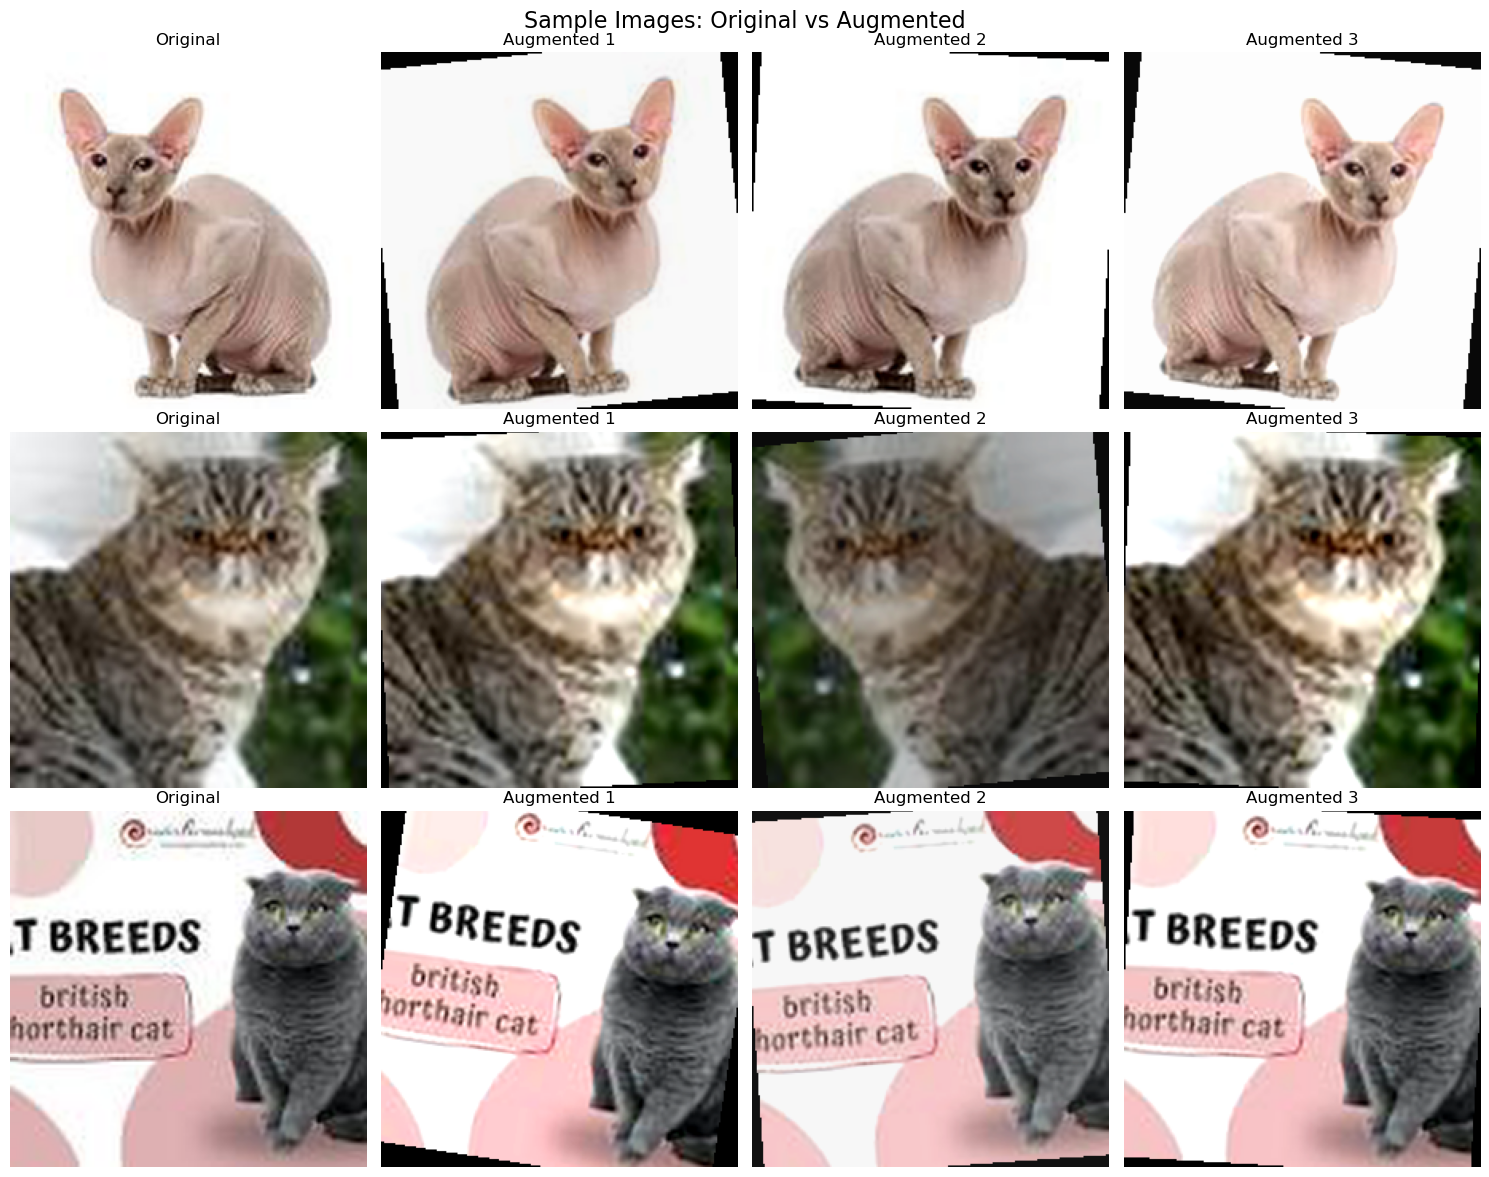


All processed images are 224x224 pixels


In [12]:
# Display original vs augmented examples
fig, axes = plt.subplots(3, 4, figsize=(15, 12))
fig.suptitle('Sample Images: Original vs Augmented', fontsize=16)

sample_original_paths = train_paths[:3]

for i, img_path in enumerate(sample_original_paths):
    # Original processed
    img_orig = augmenter.process_image(img_path, augment=False)
    axes[i, 0].imshow(img_orig)
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    
    # Show 3 augmented versions
    for j in range(1, 4):
        img_aug = augmenter.process_image(img_path, augment=True)
        axes[i, j].imshow(img_aug)
        axes[i, j].set_title(f'Augmented {j}')
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

print(f"\nAll processed images are {TARGET_SIZE[0]}x{TARGET_SIZE[1]} pixels")